<a href="https://colab.research.google.com/github/esramostafa20/A-B-testing/blob/main/humanActivityUsing_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from __future__ import print_function
from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from IPython.display import display, HTML

from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn import preprocessing

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Reshape
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import np_utils


In [ ]:
import numpy as np 
import pandas as pd
import os
print(os.listdir("../input"))


['WISDM_ar_v1.1_raw_about.txt', 'WISDM_ar_v1.1_raw.txt', 'WISDM_ar_v1.1_transformed.arff', 'WISDM_ar_v1.1_trans_about.txt']


In [ ]:
# Set some standard parameters upfront
pd.options.display.float_format = '{:.1f}'.format
sns.set() # Default seaborn look and feel
plt.style.use('ggplot')
print('keras version ', keras.__version__)
# Same labels will be reused throughout the program
LABELS = ['Downstairs',
          'Jogging',
          'Sitting',
          'Standing',
          'Upstairs',
          'Walking']
# The number of steps within one time segment
TIME_PERIODS = 80
# The steps to take from one segment to the next; if this value is equal to
# TIME_PERIODS, then there is no overlap between the segments
STEP_DISTANCE = 40

keras version  2.2.4


In [ ]:
def read_data(file_path):

    column_names = ['user-id',
                    'activity',
                    'timestamp',
                    'x-axis',
                    'y-axis',
                    'z-axis']
    df = pd.read_csv(file_path,
                     header=None,
                     names=column_names)
    # Last column has a ";" character which must be removed ...
    df['z-axis'].replace(regex=True,
      inplace=True,
      to_replace=r';',
      value=r'')
    # ... and then this column must be transformed to float explicitly
    df['z-axis'] = df['z-axis'].apply(convert_to_float)
    # This is very important otherwise the model will not fit and loss
    # will show up as NAN
    df.dropna(axis=0, how='any', inplace=True)

    return df

def convert_to_float(x):

    try:
        return np.float(x)
    except:
        return np.nan
 
def show_basic_dataframe_info(dataframe):

    # Shape and how many rows and columns
    print('Number of columns in the dataframe: %i' % (dataframe.shape[1]))
    print('Number of rows in the dataframe: %i\n' % (dataframe.shape[0]))

In [ ]:
# Load data set containing all the data from csv
df = read_data('../input/WISDM_ar_v1.1_raw.txt')

In [ ]:
# Describe the data
show_basic_dataframe_info(df)
df.tail(20)

Number of columns in the dataframe: 6
Number of rows in the dataframe: 1098203



,user-id,activity,timestamp,x-axis,y-axis,z-axis
1098184,19,Sitting,131622571443000,8.9,-1.1,2.4
1098185,19,Sitting,131622611635000,8.9,-1.2,2.5
1098186,19,Sitting,131622691469000,8.9,-1.2,2.5
1098187,19,Sitting,131622731477000,8.8,-1.3,2.5
1098188,19,Sitting,131622771486000,9.0,-1.4,2.6
1098189,19,Sitting,131622851472000,8.5,-1.5,2.6
1098190,19,Sitting,131622891511000,8.3,-1.6,2.1
1098191,19,Sitting,131622931490000,9.0,-1.5,2.3
1098192,19,Sitting,131622971498000,9.2,-1.5,2.3
1098193,19,Sitting,131623051485000,8.8,-1.2,2.3


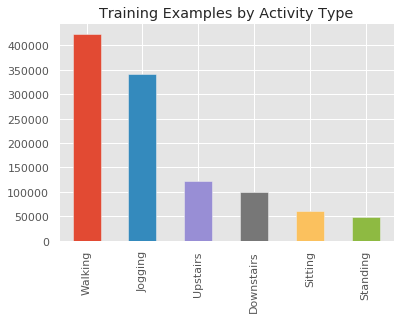

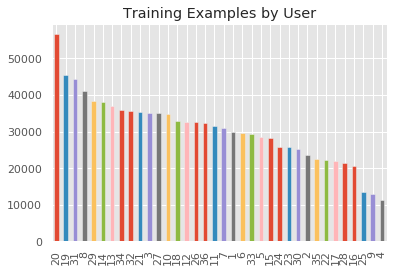

In [ ]:
# Show how many training examples exist for each of the six activities
df['activity'].value_counts().plot(kind='bar',
                                   title='Training Examples by Activity Type')
plt.show()
# Better understand how the recordings are spread across the different
# users who participated in the study
df['user-id'].value_counts().plot(kind='bar',
                                  title='Training Examples by User')
plt.show()

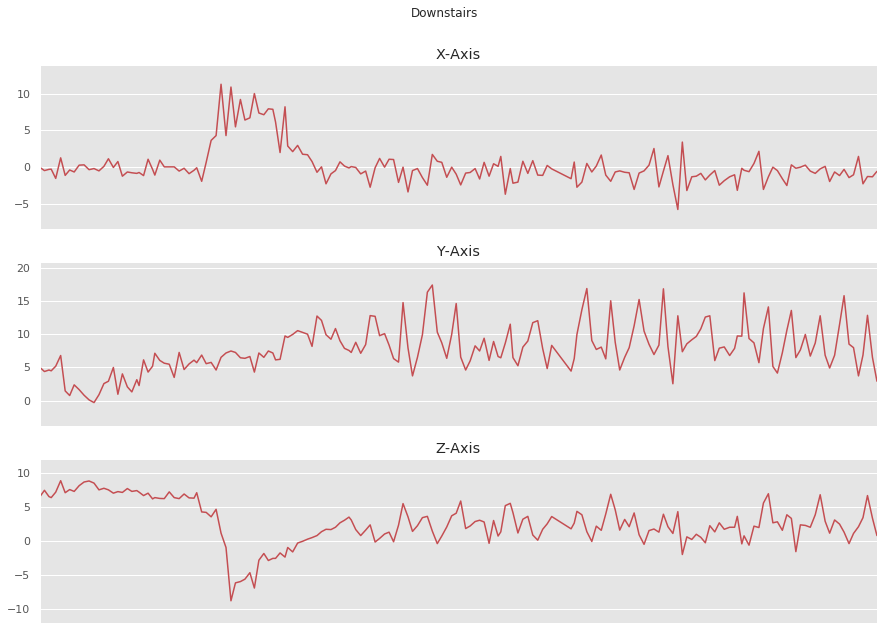

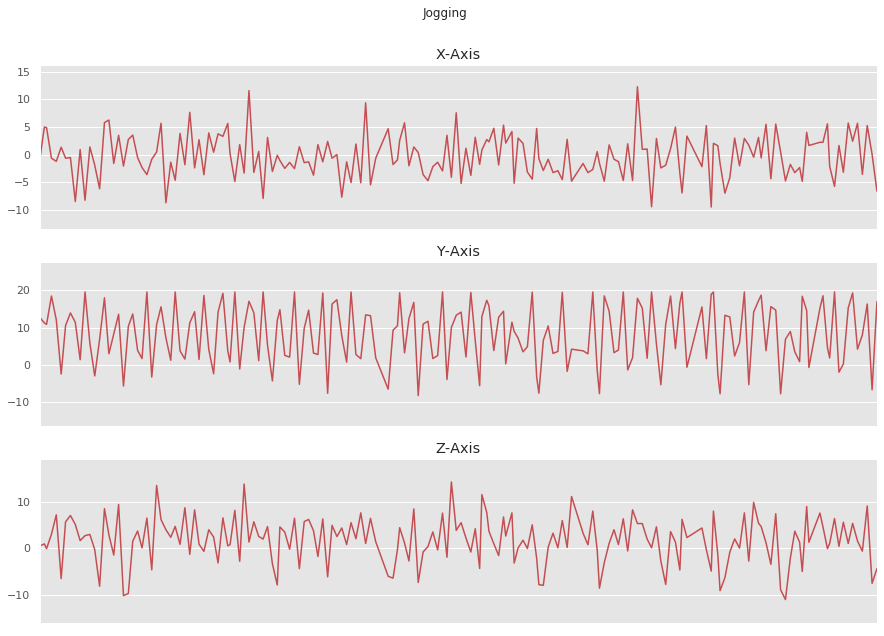

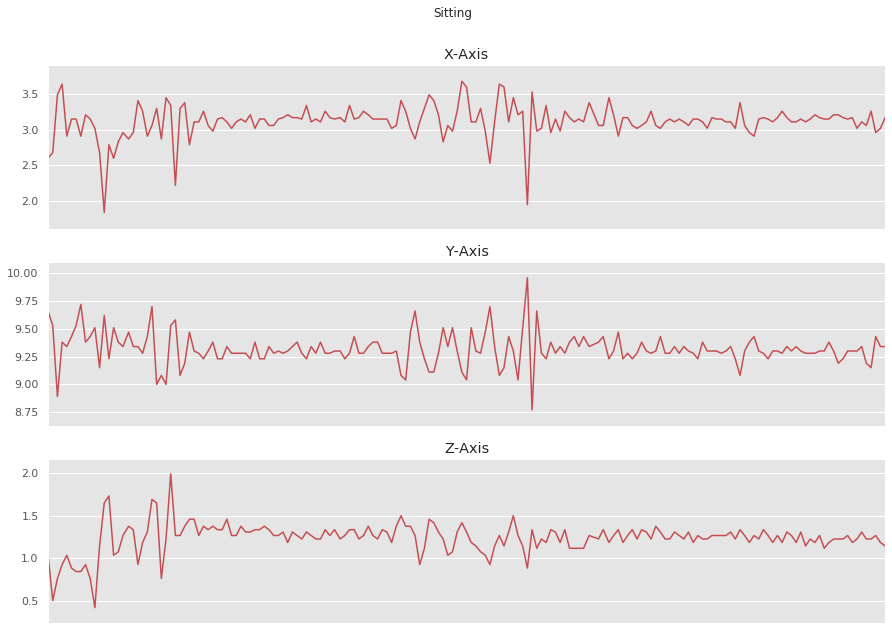

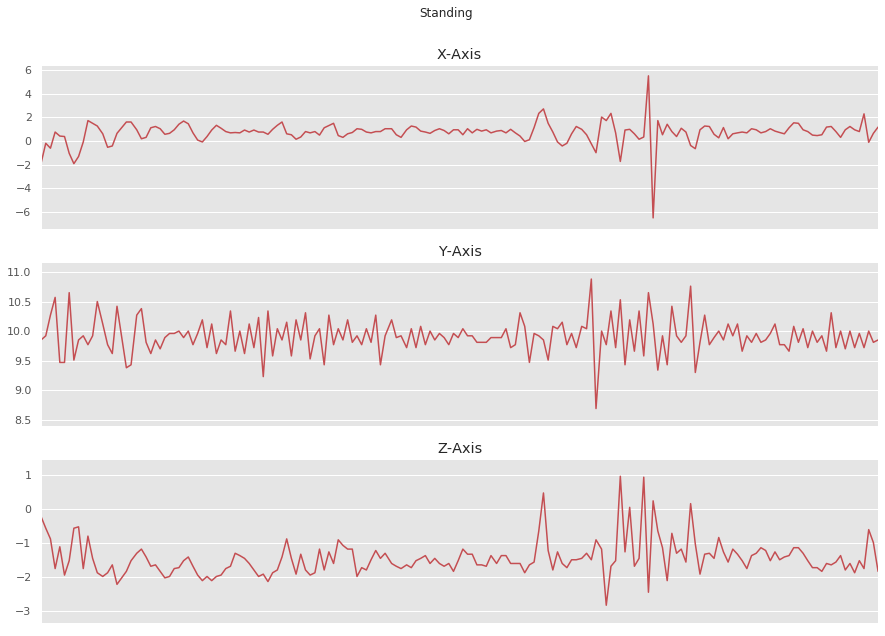

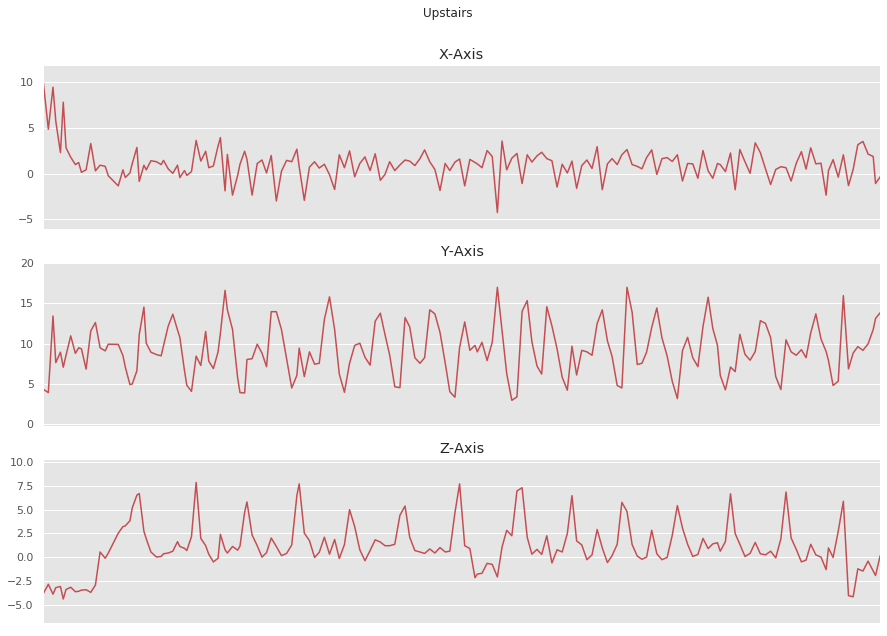

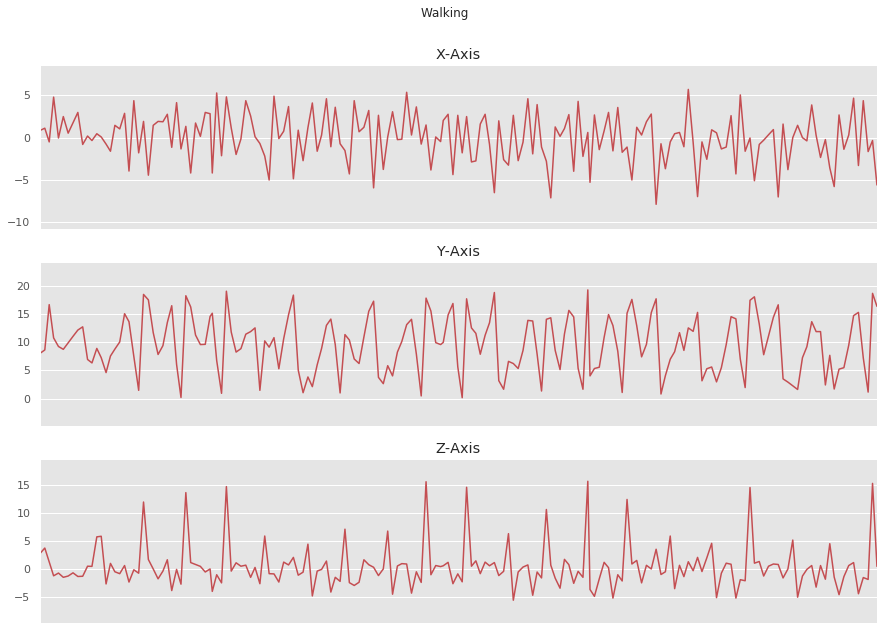

In [ ]:
def plot_activity(activity, data):

    fig, (ax0, ax1, ax2) = plt.subplots(nrows=3,
         figsize=(15, 10),
         sharex=True)
    plot_axis(ax0, data['timestamp'], data['x-axis'], 'X-Axis')
    plot_axis(ax1, data['timestamp'], data['y-axis'], 'Y-Axis')
    plot_axis(ax2, data['timestamp'], data['z-axis'], 'Z-Axis')
    plt.subplots_adjust(hspace=0.2)
    fig.suptitle(activity)
    plt.subplots_adjust(top=0.90)
    plt.show()

def plot_axis(ax, x, y, title):

    ax.plot(x, y, 'r')
    ax.set_title(title)
    ax.xaxis.set_visible(False)
    ax.set_ylim([min(y) - np.std(y), max(y) + np.std(y)])
    ax.set_xlim([min(x), max(x)])
    ax.grid(True)

for activity in np.unique(df['activity']):
    subset = df[df['activity'] == activity][:180]
    plot_activity(activity, subset)


In [ ]:
# Define column name of the label vector
LABEL = 'ActivityEncoded'
# Transform the labels from String to Integer via LabelEncoder
le = preprocessing.LabelEncoder()
# Add a new column to the existing DataFrame with the encoded values
df[LABEL] = le.fit_transform(df['activity'].values.ravel())

In [ ]:
from scipy.stats import moment

# x, y, z acceleration as features
N_FEATURES = 3

def create_segments_and_labels(df, time_steps, step, label_name):
    # Number of steps to advance in each iteration (for me, it should always
    # be equal to the time_steps in order to have no overlap between segments)
    # step = time_steps
    segments = []
    labels = []
    users =[]
    for i in range(0, len(df) - time_steps, step):
        xs = df['x-axis'].values[i: i + time_steps]
        ys = df['y-axis'].values[i: i + time_steps]
        zs = df['z-axis'].values[i: i + time_steps]
        # Retrieve the most often used label in this segment
        label = stats.mode(df[label_name][i: i + time_steps])[0][0]
        segments.append([xs, ys, zs])
        labels.append(label)
        user = stats.mode(df['user-id'][i: i + time_steps])[0][0]
        users.append(user-1)

    # Bring the segments into a better shape
    reshaped_segments = np.asarray(segments, dtype= np.float32).reshape(-1, time_steps, N_FEATURES)
    labels = np.asarray(labels)
    users = np.asarray(users)

    return reshaped_segments, labels, users

x, y, y_users = create_segments_and_labels(df,
                                          TIME_PERIODS,
                                          STEP_DISTANCE,
                                          LABEL)

In [ ]:
print(LABELS)
print(le.transform(LABELS))

['Downstairs', 'Jogging', 'Sitting', 'Standing', 'Upstairs', 'Walking']
[0 1 2 3 4 5]


In [ ]:
from keras.utils.np_utils import to_categorical

Y_one_hot       = to_categorical(y)
Y_one_hot_users = to_categorical(y_users)

In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train_one_hot, y_test_one_hot = train_test_split(x, Y_one_hot, test_size=0.33, random_state=42)

In [ ]:
import keras
from keras import models
from keras import layers

model = models.Sequential()
model.add(layers.Conv1D(160, 12, input_shape=(x_train.shape[1],x_train.shape[2]) , activation='relu'))
model.add(layers.Conv1D(128, 10, activation='relu'))
model.add(layers.Conv1D(96, 8, activation='relu'))
model.add(layers.Conv1D(64, 6, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(6, activation='softmax'))

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 69, 160)           5920      
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 60, 128)           204928    
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 53, 96)            98400     
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 48, 64)            36928     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 64)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 390       
Total para

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [ ]:
history = model.fit(x_train, y_train_one_hot, validation_data=(x_test, y_test_one_hot), epochs=150, batch_size=1024)

Train on 18394 samples, validate on 9060 samples
Epoch 1/150
18394/18394 [==============================] - 7s 358us/step - loss: 1.6694 - acc: 0.4480 - val_loss: 1.0843 - val_acc: 0.6054
Epoch 2/150
18394/18394 [==============================] - 1s 31us/step - loss: 0.9735 - acc: 0.6498 - val_loss: 0.7375 - val_acc: 0.6863
Epoch 3/150
18394/18394 [==============================] - 1s 31us/step - loss: 0.8321 - acc: 0.6930 - val_loss: 0.6149 - val_acc: 0.7882
Epoch 4/150
18394/18394 [==============================] - 1s 31us/step - loss: 0.7486 - acc: 0.7326 - val_loss: 0.4858 - val_acc: 0.8596
Epoch 5/150
18394/18394 [==============================] - 1s 31us/step - loss: 0.5773 - acc: 0.8044 - val_loss: 0.4139 - val_acc: 0.8543
Epoch 6/150
18394/18394 [==============================] - 1s 31us/step - loss: 0.5336 - acc: 0.8204 - val_loss: 0.4404 - val_acc: 0.8534
Epoch 7/150
18394/18394 [==============================] - 1s 31us/step - loss: 0.4871 - acc: 0.8389 - val_loss: 0.4000 - 

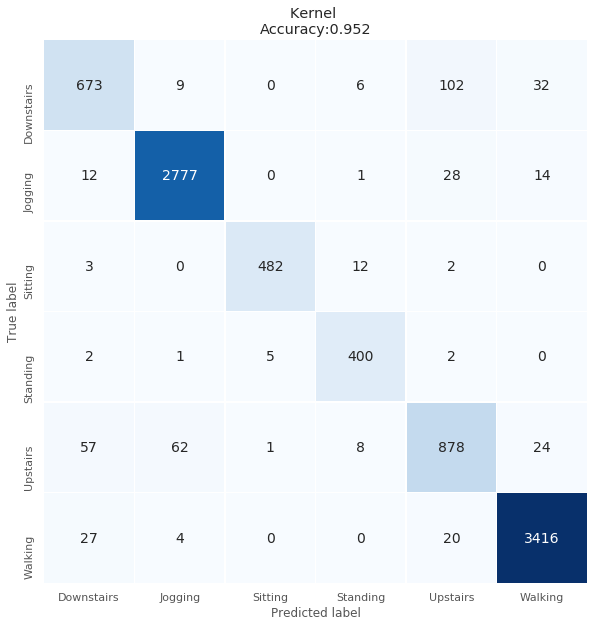

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support

y_pred = model.predict_classes(x_test)

y_test = y_test_one_hot.argmax(axis=-1)

# Creates a confusion matrix
cm = confusion_matrix(y_test, y_pred) 

# Transform to df for easier plotting
cm_df = pd.DataFrame(cm,
                     index   = ['Downstairs', 'Jogging', 'Sitting', 'Standing', 'Upstairs', 'Walking'], 
                     columns = ['Downstairs', 'Jogging', 'Sitting', 'Standing', 'Upstairs', 'Walking'])

plt.figure(figsize=(10,10))
sns.heatmap(cm_df, annot=True, fmt="d", linewidths=0.5, cmap='Blues', cbar=False, annot_kws={'size':14}, square=True)
plt.title('Kernel \nAccuracy:{0:.3f}'.format(accuracy_score(y_test, y_pred)))
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred, target_names=['Downstairs', 'Jogging', 'Sitting', 'Standing', 'Upstairs', 'Walking']))

              precision    recall  f1-score   support

  Downstairs       0.87      0.82      0.84       822
     Jogging       0.97      0.98      0.98      2832
     Sitting       0.99      0.97      0.98       499
    Standing       0.94      0.98      0.96       410
    Upstairs       0.85      0.85      0.85      1030
     Walking       0.98      0.99      0.98      3467

    accuracy                           0.95      9060
   macro avg       0.93      0.93      0.93      9060
weighted avg       0.95      0.95      0.95      9060



In [ ]:
from keras.models import Model
from matplotlib import pyplot
from numpy import expand_dims

# redefine model to output right after the first hidden layer
ixs = [0, 1, 2, 3, 4, 5, 6]
outputs = [model.layers[i].output for i in ixs]
model_view = Model(inputs=model.inputs, outputs=outputs)
# get feature map for first hidden layer
model_view.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1_input (InputLayer)  (None, 80, 3)             0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 69, 160)           5920      
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 60, 128)           204928    
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 53, 96)            98400     
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 48, 64)            36928     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 64)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
__________

In [ ]:
sample = x_train[3199].reshape(1,TIME_PERIODS, N_FEATURES)
feature_maps = model_view.predict(sample)

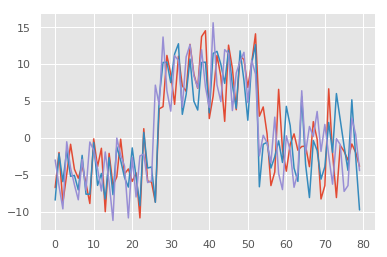

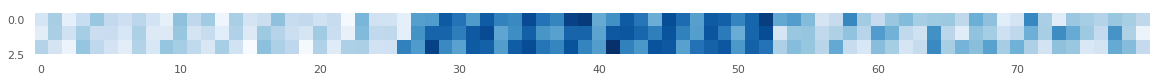

(1, 69, 160)


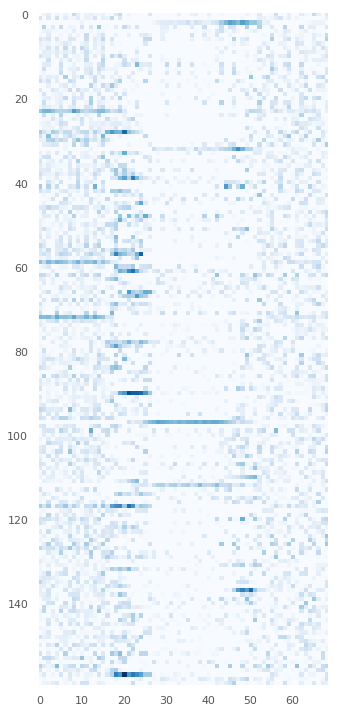

(1, 60, 128)


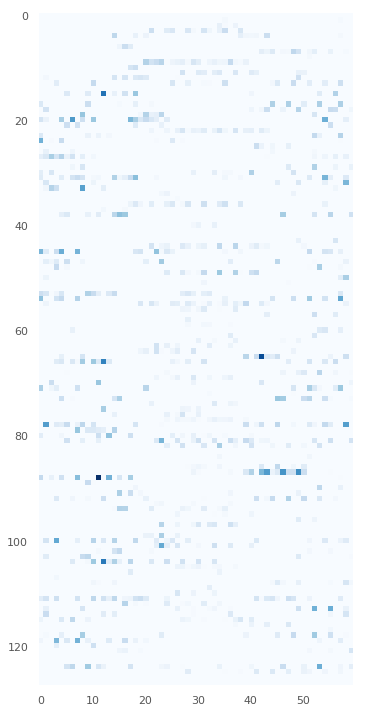

(1, 53, 96)


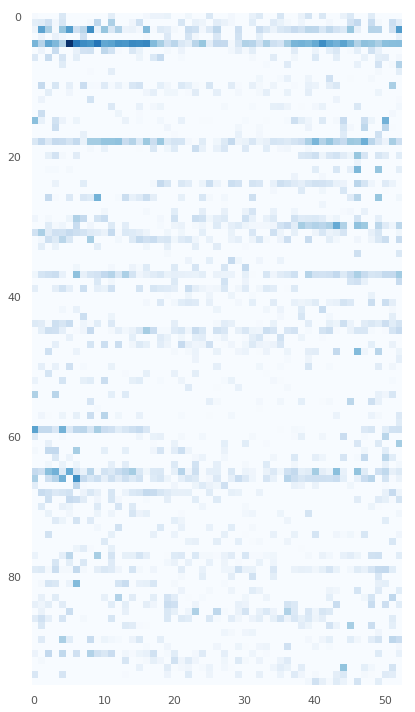

(1, 48, 64)


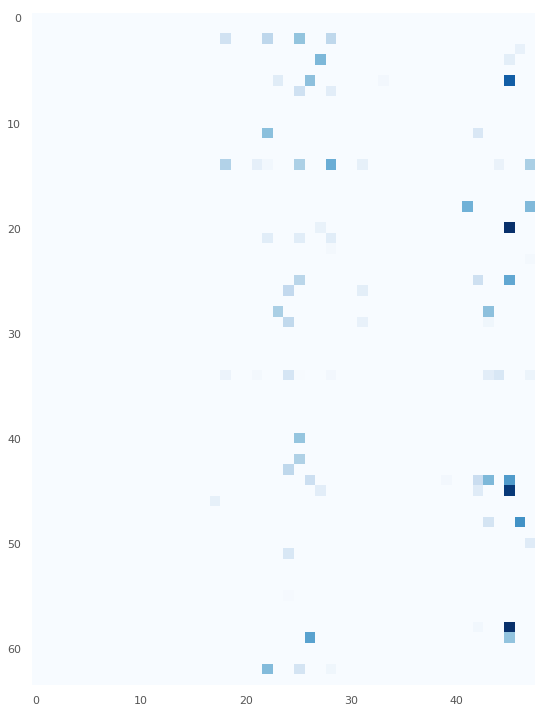

(1, 64)


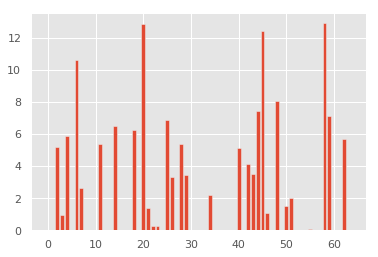

(1, 64)


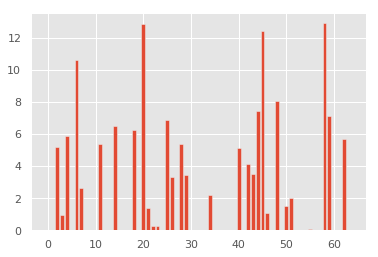

(1, 6)


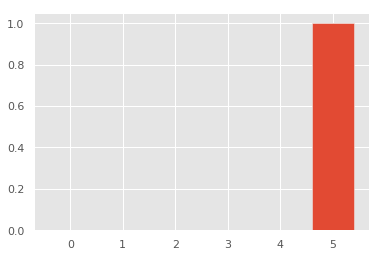

In [ ]:
plt.plot(sample.reshape(TIME_PERIODS, N_FEATURES))
plt.show()

plt.rcParams["axes.grid"] = False
plt.figure(figsize=(20,10))
plt.imshow(sample.reshape(TIME_PERIODS, N_FEATURES).transpose(), cmap='Blues')
plt.show()

for fmap in feature_maps:
    print(fmap.shape)
    if (fmap.ndim==3):
        # plot filter channel in grayscale
        plt.rcParams["axes.grid"] = False
        plt.figure(figsize=(20,10))
        plt.imshow(fmap[0,:, :].transpose(), cmap='Blues')
        plt.tight_layout()
    else:
        plt.rcParams["axes.grid"] = True
        plt.bar(range(fmap.shape[1]), fmap[0,:])
    # show the figure
    plt.show()

In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train_one_hot, y_test_one_hot = train_test_split(x, Y_one_hot_users, test_size=0.33, random_state=42)

In [ ]:
model = models.Sequential()
model.add(layers.Conv1D(192, 16, input_shape=(x_train.shape[1],x_train.shape[2]) , activation='relu'))
model.add(layers.Conv1D(160, 12, activation='relu'))
model.add(layers.Conv1D(128, 10, activation='relu'))
model.add(layers.Conv1D(96, 10, activation='relu'))
model.add(layers.Conv1D(64, 8, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(36, activation='softmax'))

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_5 (Conv1D)            (None, 65, 192)           9408      
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 54, 160)           368800    
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 45, 128)           204928    
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 36, 96)            122976    
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 29, 64)            49216     
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 64)                0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
__________

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [ ]:
history = model.fit(x_train, y_train_one_hot, validation_data=(x_test, y_test_one_hot), epochs=150, batch_size=1024)

Train on 18394 samples, validate on 9060 samples
Epoch 1/150
18394/18394 [==============================] - 2s 116us/step - loss: 3.7974 - acc: 0.0444 - val_loss: 3.4472 - val_acc: 0.0592
Epoch 2/150
18394/18394 [==============================] - 1s 47us/step - loss: 3.4445 - acc: 0.0702 - val_loss: 3.2832 - val_acc: 0.0813
Epoch 3/150
18394/18394 [==============================] - 1s 47us/step - loss: 3.3753 - acc: 0.0825 - val_loss: 3.1259 - val_acc: 0.1364
Epoch 4/150
18394/18394 [==============================] - 1s 47us/step - loss: 3.2223 - acc: 0.1193 - val_loss: 2.9965 - val_acc: 0.2240
Epoch 5/150
18394/18394 [==============================] - 1s 47us/step - loss: 3.0610 - acc: 0.1578 - val_loss: 2.7408 - val_acc: 0.2746
Epoch 6/150
18394/18394 [==============================] - 1s 47us/step - loss: 2.8927 - acc: 0.2066 - val_loss: 2.6880 - val_acc: 0.2975
Epoch 7/150
18394/18394 [==============================] - 1s 47us/step - loss: 2.7605 - acc: 0.2403 - val_loss: 2.3563 - 

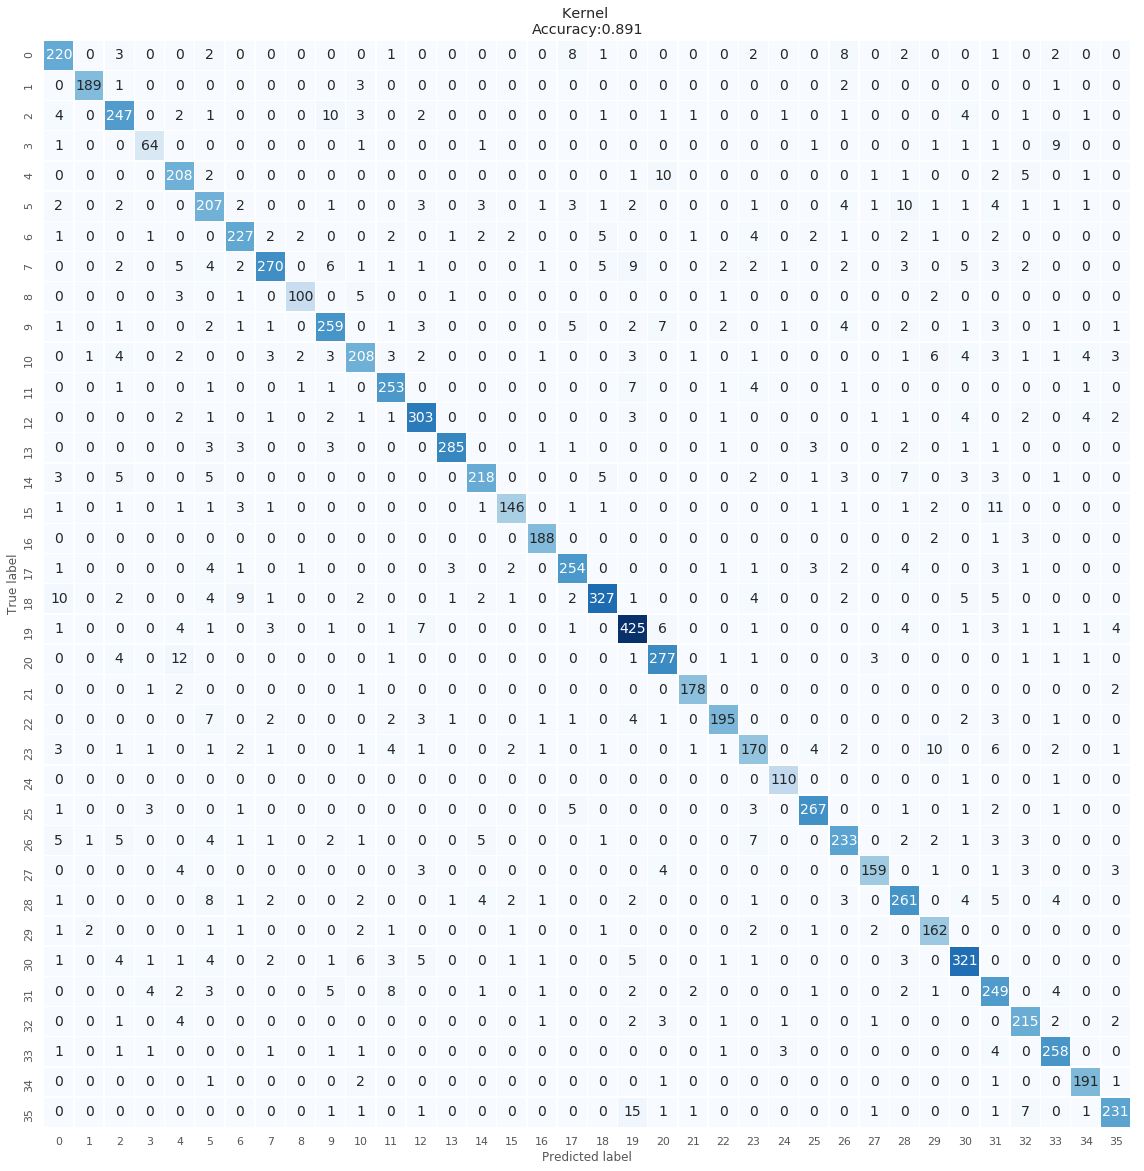

In [ ]:
y_pred = model.predict_classes(x_test)

y_test = y_test_one_hot.argmax(axis=-1)

# Creates a confusion matrix
cm = confusion_matrix(y_test, y_pred) 

# Transform to df for easier plotting
cm_df = pd.DataFrame(cm)

plt.figure(figsize=(20,20))
sns.heatmap(cm_df, annot=True, fmt="d", linewidths=0.5, cmap='Blues', cbar=False, annot_kws={'size':14}, square=True)
plt.title('Kernel \nAccuracy:{0:.3f}'.format(accuracy_score(y_test, y_pred)))
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.88      0.87       250
           1       0.98      0.96      0.97       196
           2       0.87      0.88      0.87       280
           3       0.84      0.80      0.82        80
           4       0.83      0.90      0.86       231
           5       0.78      0.82      0.80       252
           6       0.89      0.88      0.88       258
           7       0.93      0.83      0.87       327
           8       0.94      0.88      0.91       113
           9       0.88      0.87      0.87       298
          10       0.86      0.81      0.84       257
          11       0.90      0.93      0.92       271
          12       0.91      0.92      0.91       329
          13       0.97      0.94      0.95       304
          14       0.92      0.85      0.88       256
          15       0.93      0.84      0.88       173
          16       0.95      0.97      0.96       194
          17       0.90    